# Multi-label prediction with Planet Amazon dataset


In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [0]:
path = Path('./planet')
path.mkdir(parents=True, exist_ok=True)

!cp -r ../input/planet-understanding-the-amazon-from-space/train_v2.csv ./planet
!cp -r ../input/planet-understanding-the-amazon-from-space/train-jpg ./planet

## Get data

In [4]:
train_df = pd.read_csv(path/'train_v2.csv')
train_df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=256)
        .databunch(bs=64).normalize(imagenet_stats))

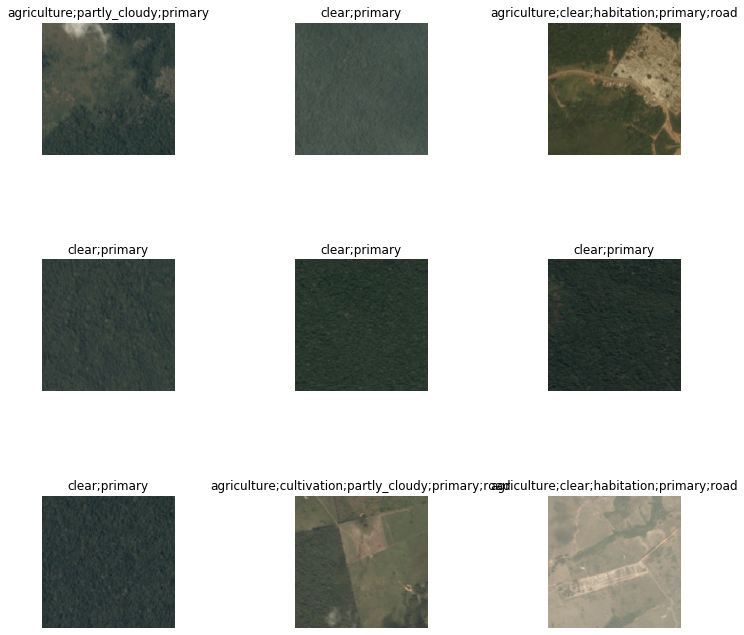

In [8]:
data.show_batch(rows=3, figsize=(10, 10))

## Training

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


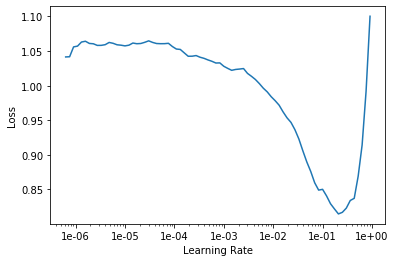

In [11]:
learn.recorder.plot()

In [14]:
lr = 0.01
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.121078,0.178086,0.930625,0.857967,00:18
1,0.149918,0.176777,0.930000,0.854518,00:18
2,0.152139,0.175995,0.939062,0.873021,00:18
3,0.132745,0.147761,0.942187,0.890967,00:18


In [0]:
learn.save('planet-amazon-stage-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


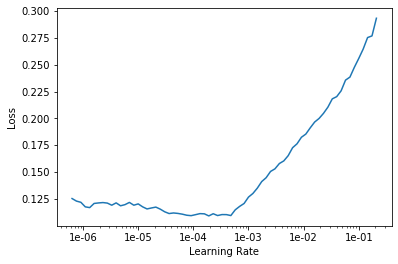

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.123589,0.166941,0.945625,0.878697,00:24
1,0.126257,0.157549,0.945312,0.886361,00:24
2,0.121278,0.147474,0.944375,0.891867,00:24
3,0.110741,0.152329,0.941250,0.889408,00:24
4,0.096440,0.148042,0.943125,0.889855,00:24


In [0]:
learn.save('planet-amazon-stage-2')

In [0]:
learn.export()

## Prediction on test set

In [0]:
print()
!cp -r ../input/planet-understanding-the-amazon-from-space/test-jpg-v2 ./planet

In [0]:
test = ImageList.from_folder(path/'test-jpg-v2')

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames,
                   'tags':labelled_preds},
                  columns=['image_name', 'tags'])

In [0]:
df.to_csv('submission.csv', index=False)

In [26]:
from IPython.display import FileLink
FileLink('submission.csv')

/content/submission.csv